# Happiness and Freedom

**A brief review of the World Happiness Report and Human Freedom Index in terms of how presence of freedom affects happiness.**.  
Analysis derived from data using the most recent World Happiness Report ([link](http://worldhappiness.report/)) and Human Freedom Index ([link](https://www.cato.org/human-freedom-index-new)).

"The secret to happiness is freedom... and the secret to freedom is courage." - Thucydides ([wikipedia](https://en.wikipedia.org/wiki/Thucydides))

It seems obvious that freedom leads to happiness but how much and how do different kinds of freedoms contribute to the overall picture?  We'll take a look at each category of freedom's relationship with reported happiness and it's own categories.  The aim is to create an overview of the two datasets, their relationship, and find strongly correlated categories from the two datasets.

##### General

* Freedom is positively correlated with happiness.  (A gut check)
* How do the two main categories of freedom, personal and economic, affect happiness and how does it differ in that effect?
* Examining the subcategories of personal freedom (top level).
* Examining the subcategories of economic freedom (top level).

#### Happiness in relation to individual freedom of movement

* How does freedom of movement affect happiness?  Individual that can move freely should be more happy than those under more restrictions.
* How does gender affect freedom of movement?  Does gender play a role in in freedom of movement.  How does this affect happiness?

##### Happiness and relative geographic isolation

* How does geographic isolation relate to happiness?  Are people in land-locked countries less happy than those in coastal countries?
* How does geographic isolation relate to freedom of movement?  Are people in land-lock countries or coastal countries more free to move around?

#### Happiness Subcategories

* How is each category related to overall happiness and rank?
* How does each correlate to the strongest freedome category, Rule of Law?


In [1]:
# imports
import sqlite3
import sqlalchemy as sa
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress

# create sqlite database and path
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Happiness_Freedom.db')

# set seaborn default theme
sns.set_palette("muted")

# multiple outputs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [81]:
# create dataframes for each report from csv
hfi_file = pd.read_csv("hfi_cc_2018.csv")
hfi = pd.DataFrame(hfi_file)

whr_file = pd.read_csv("whr_2017.csv")
whr = pd.DataFrame(whr_file)

# create database and tables from dataframe
hfi.to_sql("Human Freedom Index", con=engine, if_exists="replace")
whr.to_sql("World Happiness Report", con=engine, if_exists="replace")

# view info for each dataframe
# hfi.info()
# whr.info()

hfi.columns[:100]
hfi.columns[101:]
# hfi.columns
whr.columns

Index(['year', 'ISO_code', 'countries', 'region', 'pf_rol_procedural',
       'pf_rol_civil', 'pf_rol_criminal', 'pf_rol', 'pf_ss_homicide',
       'pf_ss_disappearances_disap', 'pf_ss_disappearances_violent',
       'pf_ss_disappearances_organized', 'pf_ss_disappearances_fatalities',
       'pf_ss_disappearances_injuries', 'pf_ss_disappearances',
       'pf_ss_women_fgm', 'pf_ss_women_missing',
       'pf_ss_women_inheritance_widows', 'pf_ss_women_inheritance_daughters',
       'pf_ss_women_inheritance', 'pf_ss_women', 'pf_ss',
       'pf_movement_domestic', 'pf_movement_foreign', 'pf_movement_women',
       'pf_movement', 'pf_religion_estop_establish',
       'pf_religion_estop_operate', 'pf_religion_estop',
       'pf_religion_harassment', 'pf_religion_restrictions', 'pf_religion',
       'pf_association_association', 'pf_association_assembly',
       'pf_association_political_establish',
       'pf_association_political_operate', 'pf_association_political',
       'pf_association_p

Index(['ef_regulation_credit_interest', 'ef_regulation_credit',
       'ef_regulation_labor_minwage', 'ef_regulation_labor_firing',
       'ef_regulation_labor_bargain', 'ef_regulation_labor_hours',
       'ef_regulation_labor_dismissal', 'ef_regulation_labor_conscription',
       'ef_regulation_labor', 'ef_regulation_business_adm',
       'ef_regulation_business_bureaucracy', 'ef_regulation_business_start',
       'ef_regulation_business_bribes', 'ef_regulation_business_licensing',
       'ef_regulation_business_compliance', 'ef_regulation_business',
       'ef_regulation', 'ef_score', 'ef_rank', 'hf_score', 'hf_rank',
       'hf_quartile'],
      dtype='object')

Index(['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high',
       'Whisker.low', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual'],
      dtype='object')

### Happiness is directly correlated with freedom

Let's start with a quick sanity check and make sure the happiness and freedom have a strong positive relationship.

In [3]:
# get overall freedom score by country from World Freedom Report
hf_score_by_country = hfi[["countries", "hf_score"]]

# get overall happiness score by country from Happiness Index
wh_score_by_country = whr[["Country", "Happiness.Score"]]
# rename "Country" column to "countries" to merge on conat with freedom index
wh_score_by_country.columns = ["countries", "hp_score"]

# coombine the two dataframes
reports_combined = pd.concat([hf_score_by_country, wh_score_by_country], sort=False)
reports_grouped = reports_combined.groupby("countries")["hf_score", "hp_score"].mean()
hf_wh_scores = reports_grouped.dropna()

# resultant dataframe is freedom and happiness scores by country
hf_wh_scores.head(5)

,hf_score,hp_score
countries,,
Albania,7.522911,4.644
Algeria,5.140803,5.872
Angola,5.499577,3.795
Argentina,6.677056,6.599
Armenia,7.413269,4.376


### How the top and bottom 10 countries compare in happiness to freedom

Let's look at how the top 10 and bottom 10 countries compare in level of happiness.

So that we can consider both the overall happiness and freedom scores for each country, we will create a Happiness/Freedom Index by getting the mean of the 2 scores.

,hf_score,hp_score,hap_free_score
count,9.000000,9.000000,9.000000
mean,8.571111,7.423333,7.998889
std,0.212394,0.100871,0.102035
min,8.120000,7.280000,7.810000
25%,8.530000,7.320000,7.950000
50%,8.610000,7.470000,8.030000
75%,8.620000,7.500000,8.060000
max,8.860000,7.540000,8.140000


,hf_score,hp_score,hap_free_score
count,9.000000,9.000000,9.000000
mean,6.170000,3.438889,4.806667
std,0.737275,0.218543,0.421129
min,4.760000,2.900000,4.110000
25%,5.640000,3.460000,4.570000
50%,6.560000,3.490000,4.960000
75%,6.670000,3.530000,5.160000
max,6.980000,3.640000,5.230000


Text(0.5,1,'Top 10 HFI Countries')

Text(0.5,0,'Country')

[Text(0,0,'Norway'),
 Text(0,0,'Denmark'),
 Text(0,0,'Iceland'),
 Text(0,0,'Switzerland'),
 Text(0,0,'Finland'),
 Text(0,0,'Netherlands'),
 Text(0,0,'Canada'),
 Text(0,0,'New Zealand'),
 Text(0,0,'Australia')]

Text(0,0.5,'HFI Score')

(0, 10)

Text(0.5,1,'Bottom 10 HFI Countries')

Text(0.5,0,'Country')

[Text(0,0,'Madagascar'),
 Text(0,0,'Haiti'),
 Text(0,0,'Liberia'),
 Text(0,0,'Guinea'),
 Text(0,0,'Togo'),
 Text(0,0,'Rwanda'),
 Text(0,0,'Syria'),
 Text(0,0,'Tanzania'),
 Text(0,0,'Burundi')]

Text(0,0.5,'HFI Score')

(0, 10)

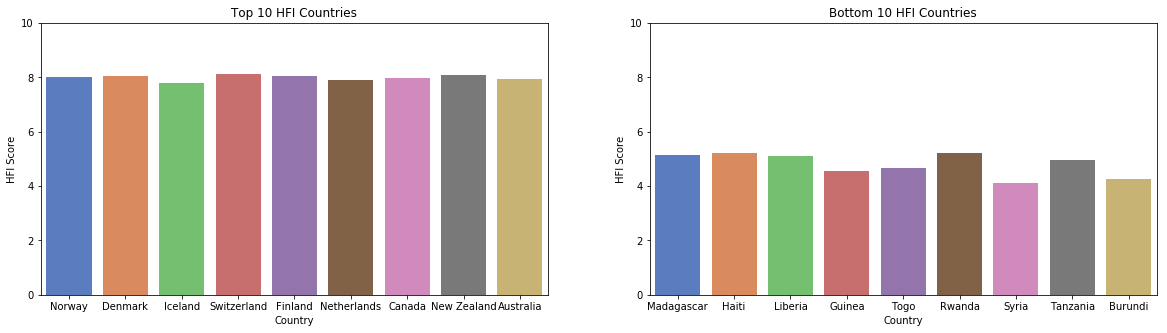

In [4]:
hf_wh_scores_reset = hf_wh_scores.reset_index()
hf_wh_scores_by_country_raw = hf_wh_scores_reset.sort_values(by=['hp_score'], ascending=False)
hf_wh_scores_by_country_raw["hap_free_score"] = hf_wh_scores_by_country_raw.mean(axis=1)
hf_wh_scores_by_country_top = hf_wh_scores_by_country_raw[:9].round(2)
hf_wh_scores_by_country_bottom = hf_wh_scores_by_country_raw[-9:].round(2)

hf_wh_scores_by_country_top.describe()
hf_wh_scores_by_country_bottom.describe()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1 = sns.barplot(x="countries", y="hap_free_score", data=hf_wh_scores_by_country_top, ax=ax1)
ax2 = sns.barplot(x="countries", y="hap_free_score", data=hf_wh_scores_by_country_bottom, ax=ax2)
ax1.set_title("Top 10 HFI Countries")
ax1.set_xlabel("Country")
ax1.set_xticklabels(hf_wh_scores_by_country_top["countries"])
ax1.set_ylabel("HFI Score")
ax1.set_ylim(0,10)
ax2.set_title("Bottom 10 HFI Countries")
ax2.set_xlabel("Country")
ax2.set_xticklabels(hf_wh_scores_by_country_bottom["countries"])
ax2.set_ylabel("HFI Score")
ax2.set_ylim(0,10)

Text(0.5,1,'Correlation of Happiness and Freedom')

Text(0.5,0,'Freedom')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.6867913461953111, intercept=0.6236133610477834, rvalue=0.6330361581269445, pvalue=1.7569182578216024e-16, stderr=0.07282491965464152)

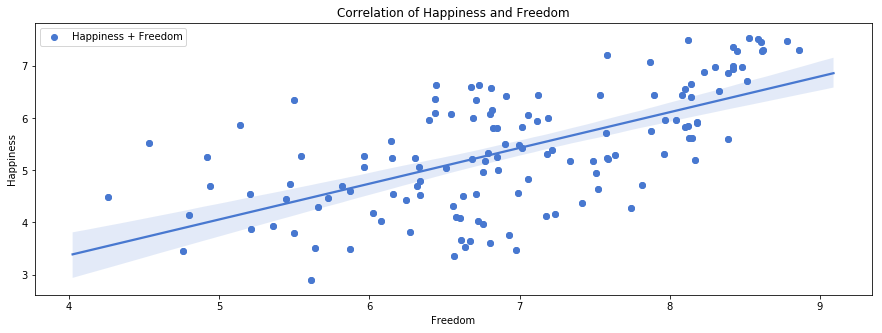

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x="hf_score", y="hp_score", data=hf_wh_scores)
points = plt.scatter(hf_wh_scores["hf_score"], hf_wh_scores["hp_score"], label="Happiness + Freedom")
ax.set_title("Correlation of Happiness and Freedom")
ax.set_xlabel("Freedom")
ax.set_ylabel("Happiness")
ax.legend();

x = hf_wh_scores["hf_score"]
y = hf_wh_scores["hp_score"]
linregress(x,y)

As expected, reported happiness and freedom have a moderate positive correlation in a linear fashion.

Slope = 0.69  
Correlation Coefficient = 0.63

In [6]:
hf_score_by_country.hf_score.describe()
wh_score_by_country.hp_score.describe()

count    1378.000000
mean        6.993444
std         1.025811
min         3.765827
25%         6.336685
50%         6.923840
75%         7.894660
max         9.126313
Name: hf_score, dtype: float64

count    155.000000
mean       5.354019
std        1.131230
min        2.693000
25%        4.505500
50%        5.279000
75%        6.101500
max        7.537000
Name: hp_score, dtype: float64

### Happiness, Personal, and Economic Freedom

How does personal freedom affect happiness?

How does economic freedom affect happiness?

In [7]:
# get personal and economic freedom scores by country from World Freedom Report
pf_ef_score_by_country = hfi[["countries", "pf_score", "ef_score"]]

# coombine the two dataframes
reports_combined = pd.concat([pf_ef_score_by_country, wh_score_by_country], sort=False)
reports_grouped = reports_combined.groupby("countries")["pf_score", "ef_score", "hp_score"].mean()
pf_ef_scores = reports_grouped.dropna()

# cleaned dataframe
pf_ef_scores.head(5)

,pf_score,ef_score,hp_score
countries,,,
Albania,7.696934,7.348889,4.644
Algeria,5.249383,5.032222,5.872
Angola,5.856932,5.142222,3.795
Argentina,8.120779,5.233333,6.599
Armenia,7.192095,7.634444,4.376


Text(0.5,1,'Happiness and Personal Freedom')

Text(0.5,0,'Peronal Freedom')

Text(0,0.5,'Happiness')

Text(0.5,1,'Happiness and Economic Freedom')

Text(0.5,0,'Economic Freedom')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.4792994286254869, intercept=1.9771523039640249, rvalue=0.5904565197157343, pvalue=4.8011190014548e-14, stderr=0.05680729070605633)

LinregressResult(slope=0.7572594668852657, intercept=0.2776175122816644, rvalue=0.5769568558547652, pvalue=2.4067155502762765e-13, stderr=0.09295607741457271)

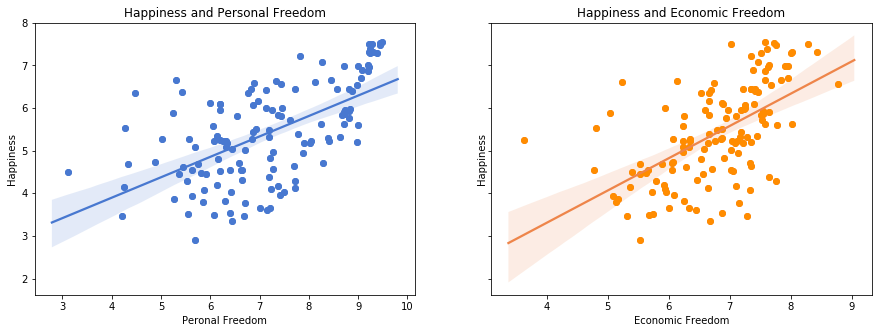

In [8]:
# regplot of happiness, personal freedom and economic freedom scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.regplot(x="pf_score", y="hp_score", data=pf_ef_scores, ax=ax1)
sns.regplot(x="ef_score", y="hp_score", data=pf_ef_scores, ax=ax2)
points1 = ax1.scatter(pf_ef_scores["pf_score"], pf_ef_scores["hp_score"], label="Happiness and Personal Freedom")
points2 = ax2.scatter(pf_ef_scores["ef_score"], pf_ef_scores["hp_score"], c="darkorange", label="Happiness and Economic Freedom")
ax1.set_title("Happiness and Personal Freedom")
ax1.set_xlabel("Peronal Freedom")
ax1.set_ylabel("Happiness")
ax2.set_title("Happiness and Economic Freedom")
ax2.set_xlabel("Economic Freedom")
ax2.set_ylabel("Happiness")

x = pf_ef_scores["pf_score"]
y = pf_ef_scores["hp_score"]
linregress(x,y)

x = pf_ef_scores["ef_score"]
y = pf_ef_scores["hp_score"]
linregress(x,y)

Both categories show a moderate to strong positive linear relationship

__Personal Freedom:__  
Slope = 0.48  
Correlation Coefficient = 0.59  

__Economic Freedom__:  
Slope = 0.78  
Correlation Coefficient = 0.58  


Both personal and economic freedom have a moderate to strong influence on happiness.

Personal Freedom:
* Slope: 0.48
* Correlation Coefficient: 0.59

Economic Freedom:
* Slope: 0.76
* Correlation Coefficient: 0.58

In [9]:
pf_ef_scores.head(3)
pf_ef_scores.describe()

,pf_score,ef_score,hp_score
countries,,,
Albania,7.696934,7.348889,4.644
Algeria,5.249383,5.032222,5.872
Angola,5.856932,5.142222,3.795


,pf_score,ef_score,hp_score
count,135.000000,135.000000,135.000000
mean,7.156347,6.773857,5.407185
std,1.397562,0.864348,1.134462
min,3.116028,3.634444,2.905000
25%,6.197193,6.233333,4.540000
50%,7.160391,6.890000,5.311000
75%,8.400550,7.403889,6.350500
max,9.476455,8.778889,7.537000


,hf_score,hp_score,pf_association,pf_expression,pf_identity,pf_movement,pf_rank,pf_religion,pf_rol,pf_score,pf_ss
countries,,,,,,,,,,,
Albania,7.511432,4.644,9.597222,8.646825,8.194444,6.666667,57.000000,9.306358,4.885893,7.646198,8.734292
Algeria,5.140803,5.872,4.388889,7.187741,0.925926,4.629630,142.666667,4.893601,4.185818,5.249383,8.001402
Angola,5.499577,3.795,3.037037,6.874736,5.092593,4.074074,123.000000,7.635638,4.474387,5.856932,8.267712


Text(0.5,0.98,'Happiness and Personal Freedoms')

Text(0.5,0,'Personal Freedom')

Text(0,0.5,'Happiness')

Text(0.5,0,'Rule of Law')

Text(0,0.5,'Happiness')

Text(0.5,0,'Safety and Security')

Text(0,0.5,'Happiness')

Text(0.5,0,'Movement')

Text(0,0.5,'Happiness')

Text(0.5,0,'Religion')

Text(0,0.5,'Happiness')

Text(0.5,0,'Association, Assembly, and Civil Society')

Text(0,0.5,'Happiness')

Text(0.5,0,'Expression and Information')

Text(0,0.5,'Happiness')

Text(0.5,0,'Identity and Relationships')

Text(0,0.5,'Happiness')

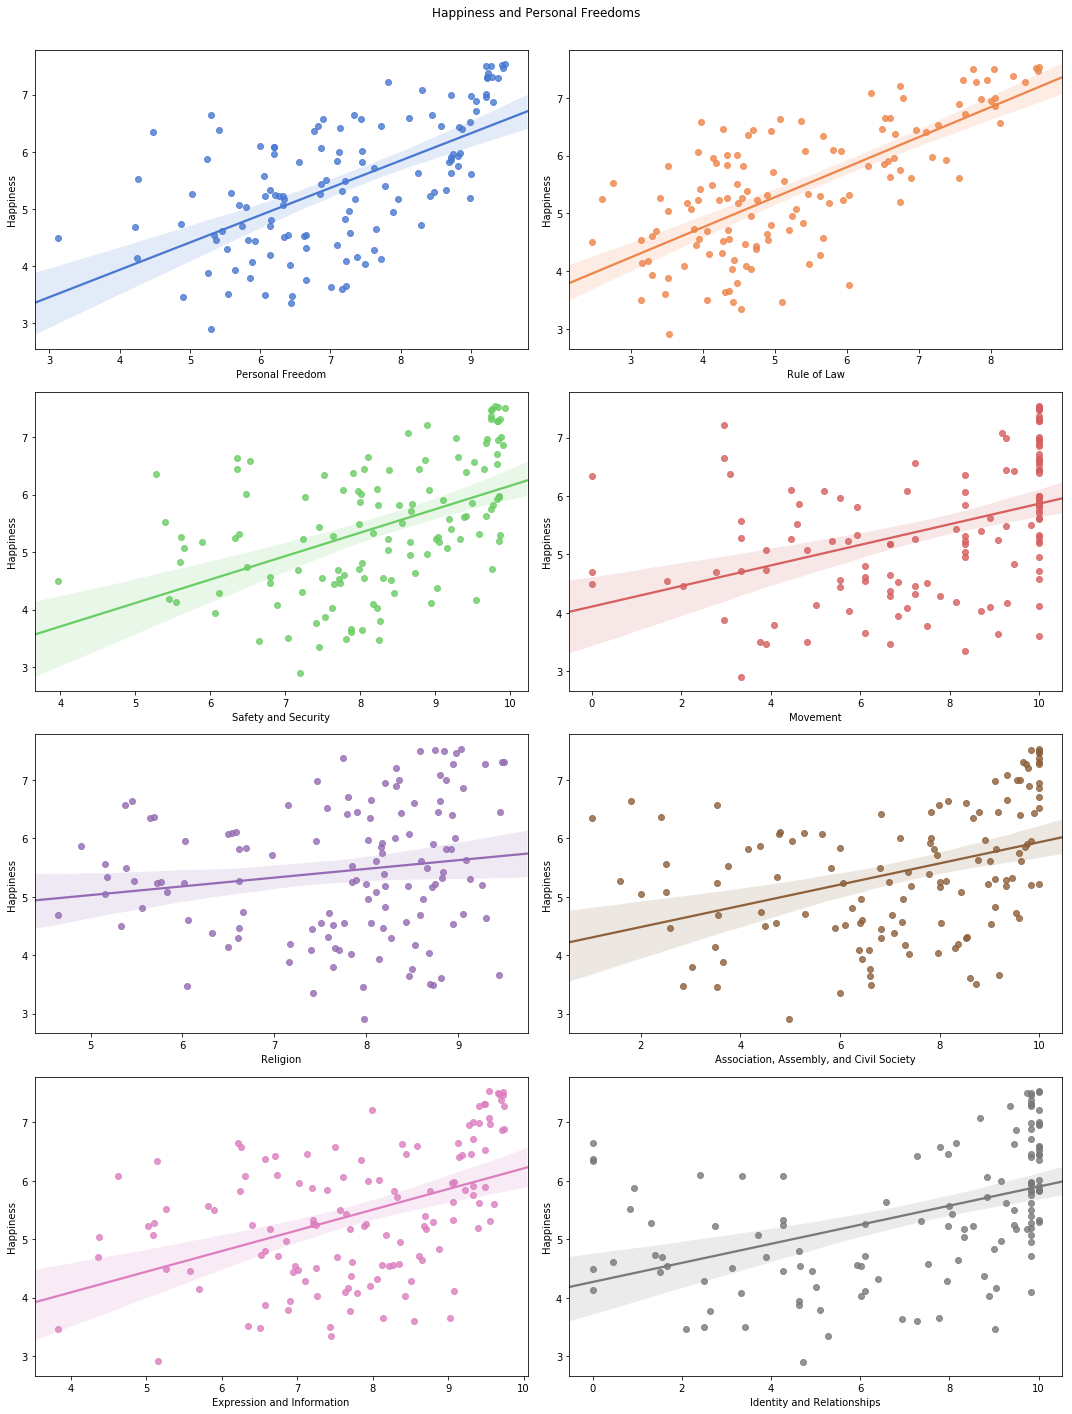

In [10]:
# Each personal freedom top level category
hfiTopLevelRaw = hfi[['countries', 'hf_score', 'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_association', 'pf_expression', 'pf_identity', 'pf_score', 'pf_rank']]
hfiTopLevelCleaned = hfiTopLevelRaw.dropna()
hfiTopLevel = hfiTopLevelCleaned.sort_values(by='pf_rank')

# coombine the two dataframes grouping by county and dropping null values
hp_pf_combined = pd.concat([hfiTopLevel, wh_score_by_country], sort=True)
hp_pf_grouped = hp_pf_combined.groupby("countries").mean()
hp_pf = hp_pf_grouped.dropna()
hp_pf.head(3)

# plot of happiness and personal freedom subtypes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Personal Freedoms")

sns.regplot(x="pf_score", y="hp_score", data=hp_pf, ax=axes[0,0])
sns.regplot(x="pf_rol", y="hp_score", data=hp_pf, ax=axes[0,1])
axes[0,0].set_xlabel("Personal Freedom")
axes[0,0].set_ylabel("Happiness")
axes[0,1].set_xlabel("Rule of Law")
axes[0,1].set_ylabel("Happiness")

sns.regplot(x="pf_ss", y="hp_score", data=hp_pf, ax=axes[1,0])
sns.regplot(x="pf_movement", y="hp_score", data=hp_pf, ax=axes[1,1])
axes[1,0].set_xlabel("Safety and Security")
axes[1,0].set_ylabel("Happiness")
axes[1,1].set_xlabel("Movement")
axes[1,1].set_ylabel("Happiness")

sns.regplot(x="pf_religion", y="hp_score", data=hp_pf, ax=axes[2,0])
sns.regplot(x="pf_association", y="hp_score", data=hp_pf, ax=axes[2,1])
axes[2,0].set_xlabel("Religion")
axes[2,0].set_ylabel("Happiness")
axes[2,1].set_xlabel("Association, Assembly, and Civil Society")
axes[2,1].set_ylabel("Happiness")

sns.regplot(x="pf_expression", y="hp_score", data=hp_pf, ax=axes[3,0])
sns.regplot(x="pf_identity", y="hp_score", data=hp_pf, ax=axes[3,1])
axes[3,0].set_xlabel("Expression and Information")
axes[3,0].set_ylabel("Happiness")
axes[3,1].set_xlabel("Identity and Relationships")
axes[3,1].set_ylabel("Happiness")

plt.tight_layout()
fig.subplots_adjust(top=0.95)


,ef_government,ef_legal,ef_money,ef_rank,ef_regulation,ef_score,ef_trade,hf_score,hp_score
countries,,,,,,,,,
Albania,7.895484,4.971587,9.633214,43.777778,6.701876,7.348889,7.538028,7.522911,4.644
Algeria,3.473555,4.155030,7.155900,147.444444,5.227641,5.032222,5.147494,5.140803,5.872
Angola,5.396990,3.270457,6.009009,145.444444,5.385903,5.142222,5.647875,5.499577,3.795


Text(0.5,0.98,'Happiness and Economic Freedoms')

Text(0.5,0,'Economic Freedom')

Text(0,0.5,'Happiness')

Text(0.5,0,'Government')

Text(0,0.5,'Happiness')

Text(0.5,0,'Legal')

Text(0,0.5,'Happiness')

Text(0.5,0,'Money')

Text(0,0.5,'Happiness')

Text(0.5,0,'Trade')

Text(0,0.5,'Happiness')

Text(0.5,0,'Regulation')

Text(0,0.5,'Happiness')

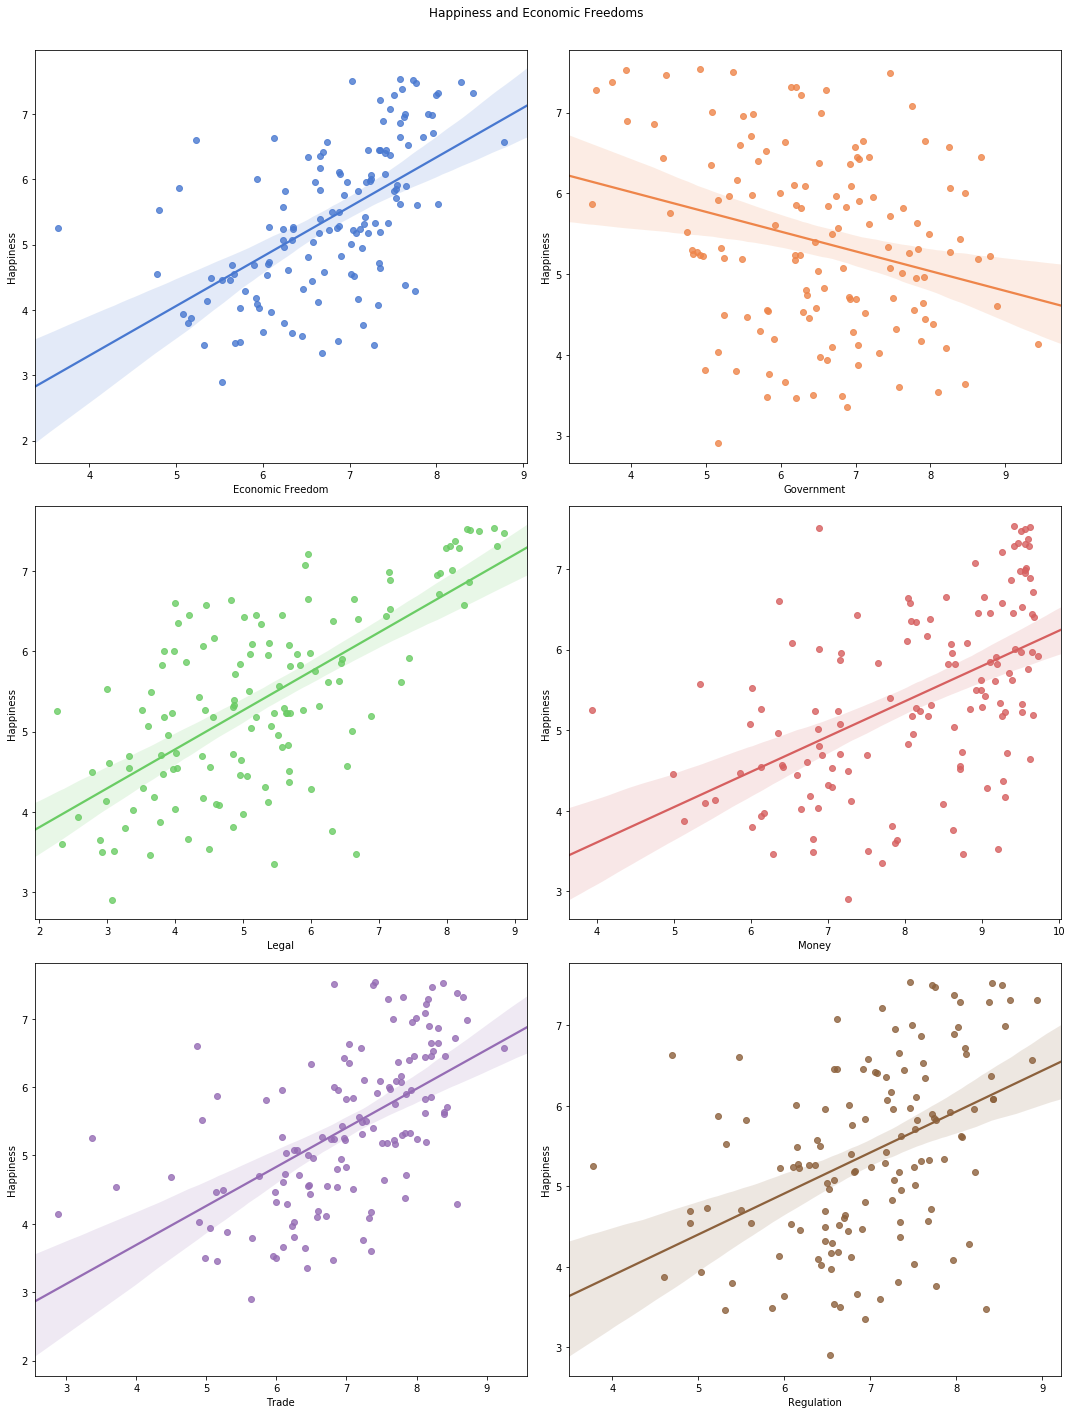

In [11]:
# Each economic freedom top level category
hfiefTopLevelRaw = hfi[['countries', 'hf_score', 'ef_government', 'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score', 'ef_rank']]
hfiefTopLevelCleaned = hfiefTopLevelRaw.dropna()
hfiefTopLevel = hfiefTopLevelCleaned.sort_values(by='ef_rank')

# coombine the two dataframes grouping by county and dropping null values
hp_ef_combined = pd.concat([hfiefTopLevel, wh_score_by_country], sort=True)
hp_ef_grouped = hp_ef_combined.groupby("countries").mean()
hp_ef = hp_ef_grouped.dropna()
hp_ef.head(3)

# plot of happiness and personal freedom subtypes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Economic Freedoms")

sns.regplot(x="ef_score", y="hp_score", data=hp_ef, ax=axes[0,0])
sns.regplot(x="ef_government", y="hp_score", data=hp_ef, ax=axes[0,1])
axes[0,0].set_xlabel("Economic Freedom")
axes[0,0].set_ylabel("Happiness")
axes[0,1].set_xlabel("Government")
axes[0,1].set_ylabel("Happiness")

sns.regplot(x="ef_legal", y="hp_score", data=hp_ef, ax=axes[1,0])
sns.regplot(x="ef_money", y="hp_score", data=hp_ef, ax=axes[1,1])
axes[1,0].set_xlabel("Legal")
axes[1,0].set_ylabel("Happiness")
axes[1,1].set_xlabel("Money")
axes[1,1].set_ylabel("Happiness")

sns.regplot(x="ef_trade", y="hp_score", data=hp_ef, ax=axes[2,0])
sns.regplot(x="ef_regulation", y="hp_score", data=hp_ef, ax=axes[2,1])
axes[2,0].set_xlabel("Trade")
axes[2,0].set_ylabel("Happiness")
axes[2,1].set_xlabel("Regulation")
axes[2,1].set_ylabel("Happiness")

plt.tight_layout()
fig.subplots_adjust(top=0.95)


In [12]:
# slope and correlation coefficient of happiness and personal freedom
print("Freedom")
x = hp_pf["pf_score"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and rule of law
print("Rule of Law")
x = hp_pf["pf_rol"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and safety and security
print("Saftey & Security")
x = hp_pf["pf_ss"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and movement
print("Movement")
x = hp_pf["pf_movement"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and religion
print("Religion")
x = hp_pf["pf_religion"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and association, assembly, and civil society
print("Assocaition, Assembly, & Civil Society")
x = hp_pf["pf_association"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and expression and information
print("Expression and Information")
x = hp_pf["pf_expression"]
y = hp_pf["hp_score"]
linregress(x,y)

# slope and correlation coefficient of happiness and identity and relationships
print("Identity & Relationships")
x = hp_pf["pf_identity"]
y = hp_pf["hp_score"]

linregress(x,y)

Freedom


LinregressResult(slope=0.4777702078099344, intercept=2.025502250415107, rvalue=0.6040153962848803, pvalue=4.4258228174790305e-14, stderr=0.056160271690753764)

Rule of Law


LinregressResult(slope=0.5209979129866191, intercept=2.673713371293317, rvalue=0.7141489422965056, pvalue=2.990674396433896e-21, stderr=0.045494206338710354)

Saftey & Security


LinregressResult(slope=0.4080258604239287, intercept=2.0741299252078877, rvalue=0.47480012725507825, pvalue=1.4929626955929245e-08, stderr=0.06737836672643274)

Movement


LinregressResult(slope=0.17634965652883489, intercept=4.106094261023734, rvalue=0.4171563227037659, pvalue=9.65709798471237e-07, stderr=0.03422752050614893)

Religion


LinregressResult(slope=0.14964831068730947, intercept=4.281119791280521, rvalue=0.15955172053151812, pvalue=0.07202557542989964, stderr=0.08248701974809576)

Assocaition, Assembly, & Civil Society


LinregressResult(slope=0.1818249970047164, intercept=4.117945123473065, rvalue=0.3820964026005794, pvalue=8.563369744181416e-06, stderr=0.03917643360180846)

Expression and Information


LinregressResult(slope=0.3539864950937236, intercept=2.673699994740398, rvalue=0.4468126638142697, pvalue=1.2445335746662996e-07, stderr=0.06314198240634508)

Identity & Relationships


LinregressResult(slope=0.16300294165747645, intercept=4.26946316335665, rvalue=0.45745928863151136, pvalue=5.6800425635965134e-08, stderr=0.028227479562365345)

#### Analysis:

**Strong relationship**: Rule of Law (0.71)

**Weak to moderate**: Saftey & Security (0.48), Movement (0.42), Association, Assembly, and Civil Society (0.38), Expression and Information (0.45), Identity and Relationships (0.46)

**None to weak** Relgion (0.16)

From the r values, Rule of Law shows to highest correlation with happiness, while all other categories except Religion show a weak to moderate correlation to happiness.

### Happiness and Movement Freedom

,hp_score,pf_movement,pf_movement_domestic,pf_movement_foreign,pf_movement_women
countries,,,,,
Albania,4.644,10.000000,10.0,10.0,10.0
Algeria,5.872,5.000000,5.0,5.0,5.0
Angola,3.795,3.333333,0.0,0.0,10.0


Text(0.5,1,'Correlation of General Happiness and Movement Freedom')

Text(0.5,0,'Movement Freedom')

Text(0,0.5,'Happiness Score')

LinregressResult(slope=0.19384737724068232, intercept=3.865210669228947, rvalue=0.40395224050215855, pvalue=3.948639184319359e-06, stderr=0.0400733806885717)

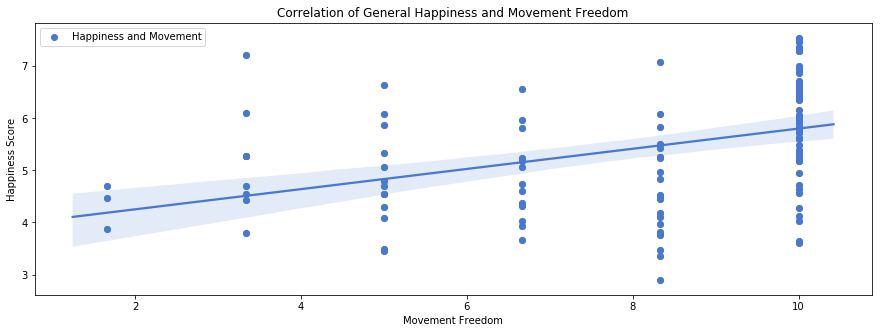

In [13]:
# Happiness and Movement Freedom

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_movement_by_country_data = "SELECT countries, pf_movement, pf_movement_domestic, pf_movement_foreign, pf_movement_women FROM 'Human Freedom Index' GROUP BY countries ORDER BY pf_score DESC"
hfi_movement_by_country_raw = pd.read_sql(hfi_movement_by_country_data, con=engine)
hfi_movement_by_country = hfi_movement_by_country_raw.dropna()

# retrieve happiness score data from World Happiness Report groupd by country and ordered by happiness score
whr_happiness_by_country_data = "SELECT Country as countries, `Happiness.Score` as hp_score FROM 'World Happiness Report' GROUP BY countries ORDER BY hp_score DESC"
whr_happiness_by_country_raw = pd.read_sql(whr_happiness_by_country_data, con=engine)
whr_happiness_by_country = whr_happiness_by_country_raw.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_movement_whr_happiness_by_country_combined = pd.concat([hfi_movement_by_country, whr_happiness_by_country], sort=True)
hfi_movement_whr_happiness_by_country_grouped = hfi_movement_whr_happiness_by_country_combined.groupby("countries")["hp_score", "pf_movement", "pf_movement_domestic", "pf_movement_foreign", "pf_movement_women"].mean()
hfi_movement_whr_happiness_by_country = hfi_movement_whr_happiness_by_country_grouped.dropna()
hfi_movement_whr_happiness_by_country.head(3)

# scatter plot analysis with linear regression
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x="pf_movement", y="hp_score", data=hfi_movement_whr_happiness_by_country)
points = plt.scatter(hfi_movement_whr_happiness_by_country["pf_movement"], hfi_movement_whr_happiness_by_country["hp_score"], label="Happiness and Movement")
ax.set_title("Correlation of General Happiness and Movement Freedom")
ax.set_xlabel("Movement Freedom")
ax.set_ylabel("Happiness Score")
ax.legend()

x = hfi_movement_whr_happiness_by_country["pf_movement"]
y = hfi_movement_whr_happiness_by_country["hp_score"]
linregress(x,y)

Slope = 0.19   
Correlation Coefficient = 0.40

## Happiness and types of movment

,hp_score,pf_movement,pf_movement_domestic,pf_movement_foreign,pf_movement_women
countries,,,,,
Albania,4.644,10.000000,10.0,10.0,10.0
Algeria,5.872,5.000000,5.0,5.0,5.0
Angola,3.795,3.333333,0.0,0.0,10.0


Text(0.5,0.98,'Happiness and Freedom of Movement')

Text(0.5,0,'Freedom of Movement')

Text(0,0.5,'Happiness')

Text(0.5,0,'Domestic Travel')

Text(0,0.5,'Happiness')

Text(0.5,0,'Foreign Travel')

Text(0,0.5,'Happiness')

Text(0.5,0,"Women's Movement")

Text(0,0.5,'Happiness')

LinregressResult(slope=0.19384737724068232, intercept=3.865210669228947, rvalue=0.40395224050215855, pvalue=3.948639184319359e-06, stderr=0.0400733806885717)

LinregressResult(slope=0.12524635510928528, intercept=4.486462509188343, rvalue=0.3986688491682361, pvalue=5.41240705840397e-06, stderr=0.026301255055421024)

LinregressResult(slope=0.09322213476133365, intercept=4.733206502033217, rvalue=0.2967332753905574, pvalue=0.0009038423009149428, stderr=0.02738719365529842)

LinregressResult(slope=0.11382046038111927, intercept=4.411231037694739, rvalue=0.18839487581167114, pvalue=0.0376988147725481, stderr=0.05416433358800328)

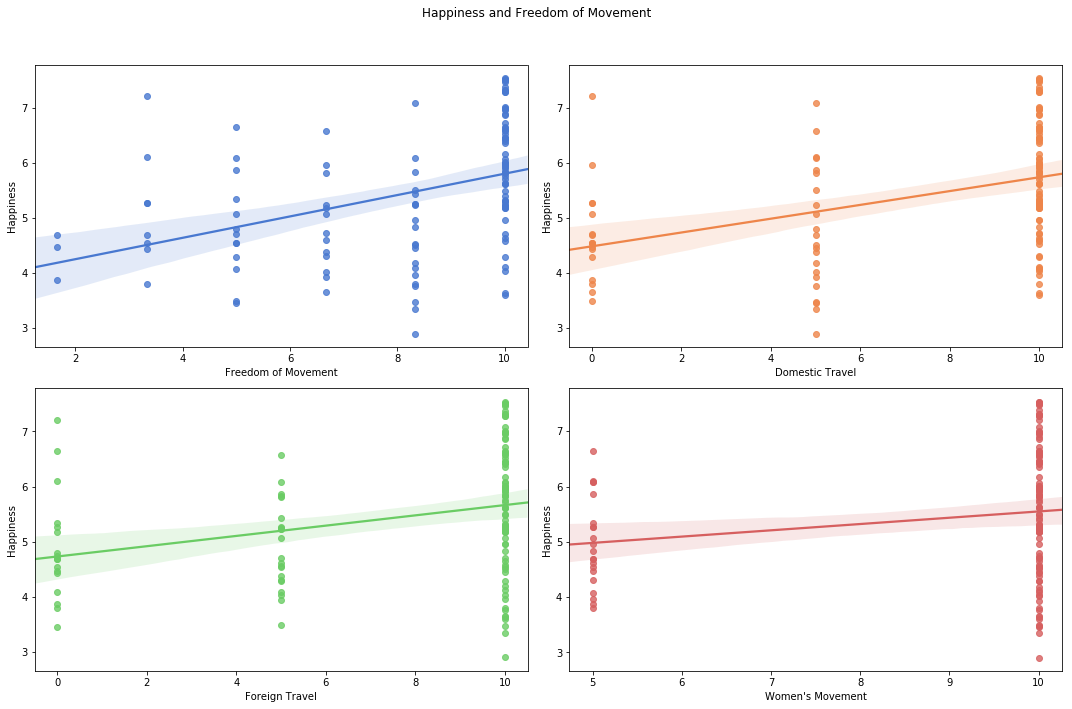

In [34]:
# Correlation of happiness and all movement freedom types

hfi_movement_whr_happiness_by_country.head(3)

# plot of happiness freedom and personal freedom subtypes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Happiness and Freedom of Movement")

sns.regplot(x="pf_movement", y="hp_score", data=hfi_movement_whr_happiness_by_country, ax=axes[0,0])
sns.regplot(x="pf_movement_domestic", y="hp_score", data=hfi_movement_whr_happiness_by_country, ax=axes[0,1])
axes[0,0].set_xlabel("Freedom of Movement")
axes[0,0].set_ylabel("Happiness")
axes[0,1].set_xlabel("Domestic Travel")
axes[0,1].set_ylabel("Happiness")

sns.regplot(x="pf_movement_foreign", y="hp_score", data=hfi_movement_whr_happiness_by_country, ax=axes[1,0])
sns.regplot(x="pf_movement_women", y="hp_score", data=hfi_movement_whr_happiness_by_country, ax=axes[1,1])
axes[1,0].set_xlabel("Foreign Travel")
axes[1,0].set_ylabel("Happiness")
axes[1,1].set_xlabel("Women's Movement")
axes[1,1].set_ylabel("Happiness")

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = hfi_movement_whr_happiness_by_country["pf_movement"]
y = hfi_movement_whr_happiness_by_country["hp_score"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["pf_movement_domestic"]
y = hfi_movement_whr_happiness_by_country["hp_score"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["pf_movement_foreign"]
y = hfi_movement_whr_happiness_by_country["hp_score"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["pf_movement_women"]
y = hfi_movement_whr_happiness_by_country["hp_score"]
linregress(x,y)

### Analysis:

**Weak to moderate**:  Domestic Travel (0.40), Foreign Trave (0.30), Women's Movement (0.19) 

Domestic travel has the strongest correlation with happiness which seems to be a benefit for isolated countries.

## Happiness and geographic isolation

In [15]:
# get list of land locked countries
land_locked_countries = pd.Series(["Afghanistan", "Andorra", "Armenia", "Artsakh", "Austria", "Azerbaijan", "Belarus", "Bhutan", "Bolivia", "Botswana", "Burkina Faso", "Burundi", "Central African Republic", "Chad", "Czech Republic", "Ethiopia", "Hungary","Kazakhstan", "Kosovo", "Kyrgyzstan", "Laos", "Lesotho", "Liechtenstein", "Luxembourg", "Macedonia", "Malawi", "Mali", "Moldova", "Mongolia", "Nepal", "Niger", "Paraguay", "Rwanda", "San Marino" , "Serbia", "Slovakia", "South Ossetia", "South Sudan", "Swaziland", "Switzerland","Tajikistan", "Transnistria", "Turkmenistan", "Uganda", "Uzbekistan","Vatican City", "West Bank", "Zambia", "Zimbabwe"])

,hf_score,hp_score,geography
21,5.612288,2.905,Landlocked
119,6.562701,3.349,Coastal
117,4.759178,3.462,Coastal


Text(0.5,1,'Happiness range in countries based on geography')

Text(0.5,0,'Geography')

Text(0,0.5,'Happiness')

(0, 10)

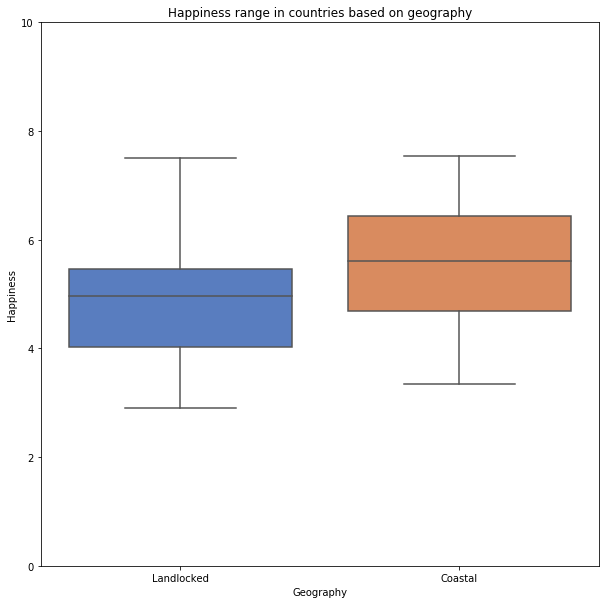

In [152]:
# create list of land-locked countries and coastal countries
landlocked_happiness = hf_wh_scores_by_country_raw.loc[hf_wh_scores_by_country_raw["countries"].isin(land_locked_countries)]
coastal_happiness = hf_wh_scores_by_country_raw.loc[~hf_wh_scores_by_country_raw["countries"].isin(land_locked_countries)]

# combine dataframes
combined_happiness_raw = pd.concat([landlocked_happiness, coastal_happiness])
combined_happiness = combined_happiness_raw.drop(columns=["hap_free_score"])

# mark countries as landlocked or coastal
combined_happiness["geography"] = ""
combined_happiness["geography"] = np.where(combined_happiness["countries"].isin(land_locked_countries), "Landlocked", "Coastal")
combined_happiness = combined_happiness.sort_values(by="hp_score").drop(columns=["countries"])
combined_happiness.head(3)

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="geography", y="hp_score", data=combined_happiness)
ax.set_title("Happiness range in countries based on geography")
ax.set_xlabel("Geography")
ax.set_ylabel("Happiness")
ax.set_ylim(0, 10)



Text(0.5,1,'Happiness in Landlocked vs Coastal Countries')

Text(0.5,0,'Countries')

Text(0,0.5,'Happiness')

(0, 10)

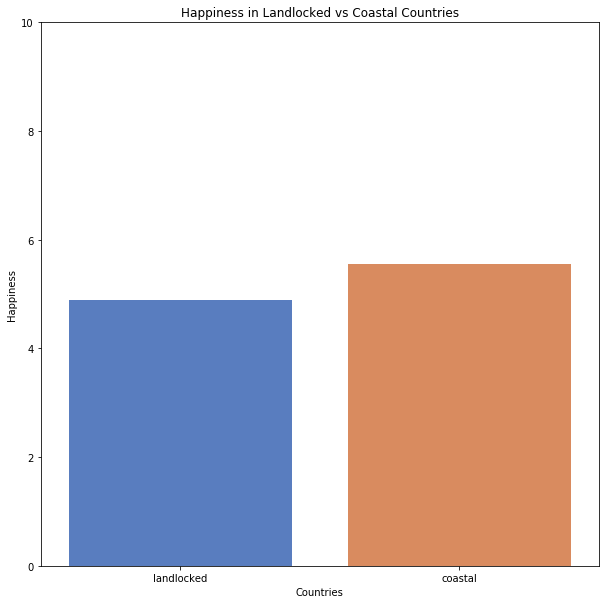

In [117]:
# avg happiness in landlocked vs coastal countries

landlocked_happiness_mean = landlocked_happiness["hp_score"].mean()
coastal_happiness_mean = coastal_happiness["hp_score"].mean()

# combine into data array

combined_happiness_mean = pd.DataFrame([landlocked_happiness_mean, coastal_happiness_mean]).T 

combined_happiness_mean.columns = ["landlocked", "coastal"]
combined_happiness_mean.index = ["happiness"]

# plot

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(data=combined_happiness_mean);
ax.set_title("Happiness in Landlocked vs Coastal Countries")
ax.set_xlabel("Countries")
ax.set_ylabel('Happiness')
ax.set_ylim(0, 10)

Text(0.5,1,'Correlation of Happiness and Freedom in Landlocked vs non-Landlocked countries')

Text(0.5,0,'Freedom')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.8786316163050915, intercept=-1.0922589058503362, rvalue=0.7158647604073939, pvalue=8.687374465791945e-06, stderr=0.16195744036889148)

LinregressResult(slope=0.6303437707662627, intercept=1.1371292209288013, rvalue=0.6179284067523297, pvalue=2.1823642234112312e-12, stderr=0.0790264944123492)

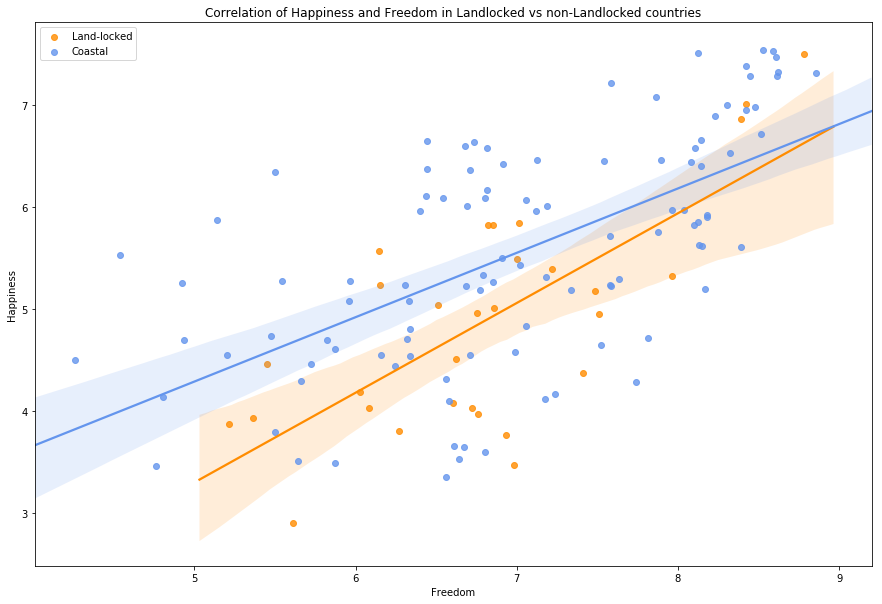

In [24]:
# Regplots of happiness and freedom for landlocked vs coastal countries

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="hf_score", y="hp_score", data=landlocked_happiness, color="darkorange", label="Land-locked")
sns.regplot(x="hf_score", y="hp_score", data=coastal_happiness, color="cornflowerblue", label="Coastal")
ax.set_title("Correlation of Happiness and Freedom in Landlocked vs non-Landlocked countries")
ax.set_xlabel("Freedom")
ax.set_ylabel("Happiness")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_movement_happiness["hf_score"]
y = landlocked_movement_happiness["hp_score"]
linregress(x,y)

x = coastal_movement_happiness["hf_score"]
y = coastal_movement_happiness["hp_score"]
linregress(x,y)

### Happiness and movement freedom in land-locked versus coastal countries

,countries,hp_score,pf_movement,pf_movement_domestic,pf_movement_foreign,pf_movement_women
0,Albania,4.644,10.000000,10.0,10.0,10.0
1,Algeria,5.872,5.000000,5.0,5.0,5.0
2,Angola,3.795,3.333333,0.0,0.0,10.0


Text(0.5,1,'Correlation of Happiness and Freedom of Movement in Landlocked vs non-Landlocked countries')

Text(0.5,0,'Freedom of Movement')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.2634076329039947, intercept=2.6653812897946585, rvalue=0.4509848188048423, pvalue=0.018226123164837238, stderr=0.10426055671413943)

LinregressResult(slope=0.18566767450354887, intercept=4.109416343979116, rvalue=0.42531559049079953, pvalue=1.7355633151802674e-05, stderr=0.0409688474579896)

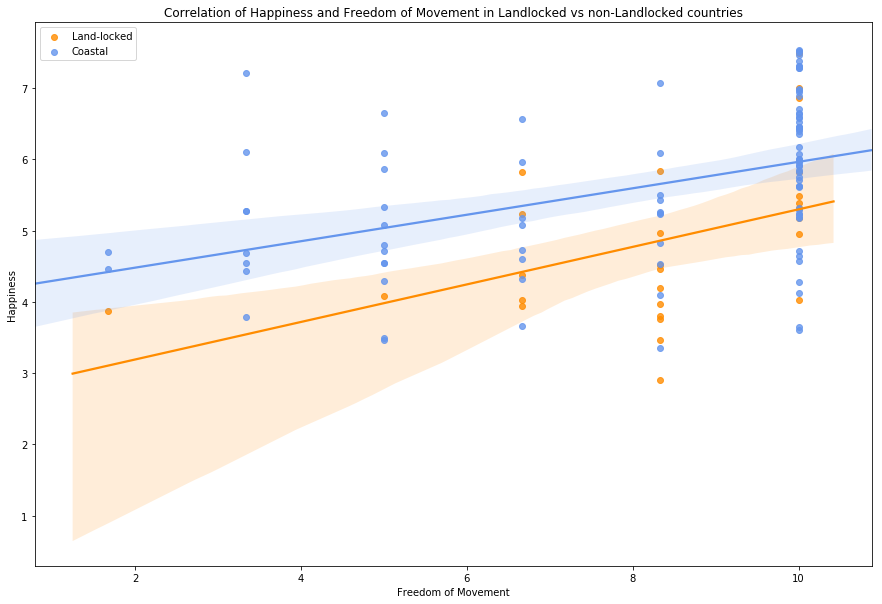

In [18]:
# reset index of dataframe from country list to index
hfi_movement_whr_happiness_by_country_reset = hfi_movement_whr_happiness_by_country.reset_index()
hfi_movement_whr_happiness_by_country_reset.head(3)

# create list of land-locked countries and coastal countries
landlocked_movement_happiness = hfi_movement_whr_happiness_by_country_reset.loc[hfi_movement_whr_happiness_by_country_reset["countries"].isin(land_locked_countries)]
coastal_movement_happiness = hfi_movement_whr_happiness_by_country_reset.loc[~hfi_movement_whr_happiness_by_country_reset["countries"].isin(land_locked_countries)]

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="pf_movement", y="hp_score", data=landlocked_movement_happiness, color="darkorange", label="Land-locked")
sns.regplot(x="pf_movement", y="hp_score", data=coastal_movement_happiness, color="cornflowerblue", label="Coastal")
ax.set_title("Correlation of Happiness and Freedom of Movement in Landlocked vs non-Landlocked countries")
ax.set_xlabel("Freedom of Movement")
ax.set_ylabel("Happiness")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_movement_happiness["pf_movement"]
y = landlocked_movement_happiness["hp_score"]
linregress(x,y)

x = coastal_movement_happiness["pf_movement"]
y = coastal_movement_happiness["hp_score"]
linregress(x,y)


**Land-locked:**
Correllation Coefficient: 0.45  
**Coastal**
Correllation Coefficient: 0.43

,countries,pf_rol,pf_rol_procedural,pf_rol_civil,pf_rol_criminal
0,Norway,8.7,9.400000,8.162278,8.457878
1,Sweden,8.5,9.500000,7.780177,8.230554
2,Finland,8.7,9.666667,7.884439,8.673985


,countries,hp_score,pf_rol,pf_rol_procedural,pf_rol_civil,pf_rol_criminal
0,Albania,4.644,4.9,5.666667,5.074785,4.100516
1,Argentina,6.599,5.3,6.333333,5.366584,4.343652
2,Australia,7.284,7.8,8.800000,7.232831,7.236429


Text(0.5,1,'Happiness and Rule of Law in Landlocked vs non-Landlocked countries')

Text(0.5,0,'Rule of Law')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.3156766270845451, intercept=3.2925441143025735, rvalue=0.3510414772345616, pvalue=0.16710165074245756, stderr=0.21741083093110536)

LinregressResult(slope=0.46065690745502824, intercept=3.083587430161188, rvalue=0.6753375912198023, pvalue=1.4309335017899922e-10, stderr=0.06100555419977643)

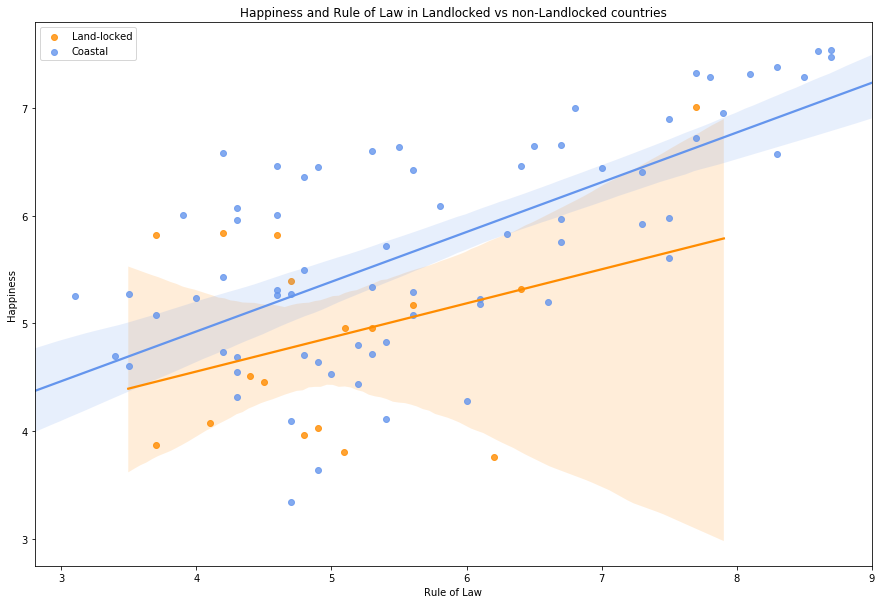

In [20]:
# combine Rule of Law from HFI with Happiness 

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_rol_data = "SELECT countries, pf_rol, pf_rol_procedural, pf_rol_civil, pf_rol_criminal FROM 'Human Freedom Index' GROUP BY countries ORDER BY pf_score DESC"
hfi_rol_raw = pd.read_sql(hfi_rol_data, con=engine)
hfi_rol_by_country = hfi_rol_raw.dropna()

hfi_rol_by_country.head(3)

# coombine the two dataframes grouping by county and dropping null values
hfi_rol_whr_happiness_by_country_combined = pd.concat([hfi_rol_by_country, whr_happiness_by_country], sort=True)
hfi_rol_whr_happiness_by_country_grouped = hfi_rol_whr_happiness_by_country_combined.groupby("countries")["hp_score", "pf_rol", "pf_rol_procedural", "pf_rol_civil", "pf_rol_criminal"].mean()
hfi_rol_whr_happiness_by_country_cleaned = hfi_rol_whr_happiness_by_country_grouped.dropna()
hfi_rol_whr_happiness_by_country = hfi_rol_whr_happiness_by_country_cleaned.reset_index()

hfi_rol_whr_happiness_by_country.head(3)

# list non land locked countries

landlocked_rol_happiness = hfi_rol_whr_happiness_by_country.loc[hfi_rol_whr_happiness_by_country["countries"].isin(land_locked_countries)]
coastal_rol_happiness = hfi_rol_whr_happiness_by_country.loc[~hfi_rol_whr_happiness_by_country["countries"].isin(land_locked_countries)]

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="pf_rol", y="hp_score", data=landlocked_rol_happiness, color="darkorange", label="Land-locked")
sns.regplot(x="pf_rol", y="hp_score", data=coastal_rol_happiness, color="cornflowerblue", label="Coastal")
ax.set_title("Happiness and Rule of Law in Landlocked vs non-Landlocked countries")
ax.set_xlabel("Rule of Law")
ax.set_ylabel("Happiness")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_rol_happiness["pf_rol"]
y = landlocked_rol_happiness["hp_score"]
linregress(x,y)

x = coastal_rol_happiness["pf_rol"]
y = coastal_rol_happiness["hp_score"]
linregress(x,y)

#### Happiness Subcategories

* How is each category related to overall happiness and rank?
* How does each correlate to the strongest freedome category, Rule of Law?

In [85]:
whr.columns

whr



Index(['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high',
       'Whisker.low', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual'],
      dtype='object')

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
5,Netherlands,6,7.377,7.427426,7.326574,1.503945,1.428939,0.810696,0.585384,0.470490,0.282662,2.294804
6,Canada,7,7.316,7.384403,7.247597,1.479204,1.481349,0.834558,0.611101,0.435540,0.287372,2.187264
7,New Zealand,8,7.314,7.379510,7.248490,1.405706,1.548195,0.816760,0.614062,0.500005,0.382817,2.046456
8,Sweden,9,7.284,7.344095,7.223905,1.494387,1.478162,0.830875,0.612924,0.385399,0.384399,2.097538
9,Australia,10,7.284,7.356651,7.211349,1.484415,1.510042,0.843887,0.601607,0.477699,0.301184,2.065211


Text(0.5,0.98,'Happiness and Categories of Happiness')

Text(0,0.5,'Happiness')

Text(0.5,0,'Economy')

Text(0,0.5,'Happiness')

Text(0.5,0,'Family')

Text(0,0.5,'Happiness')

Text(0.5,0,'Freedom')

Text(0,0.5,'Happiness')

Text(0.5,0,'Health & Life Expectancy')

Text(0,0.5,'Happiness')

Text(0.5,0,'Generosity')

Text(0.5,0,'Trust in Government')

Text(0,0.5,'Happiness')

Text(0.5,0,'Dystopia Residual')

Text(0,0.5,'Happiness')

(0.03676434140336969,
 1.9365936848606855,
 -0.008473322591293742,
 5.609376149981793)

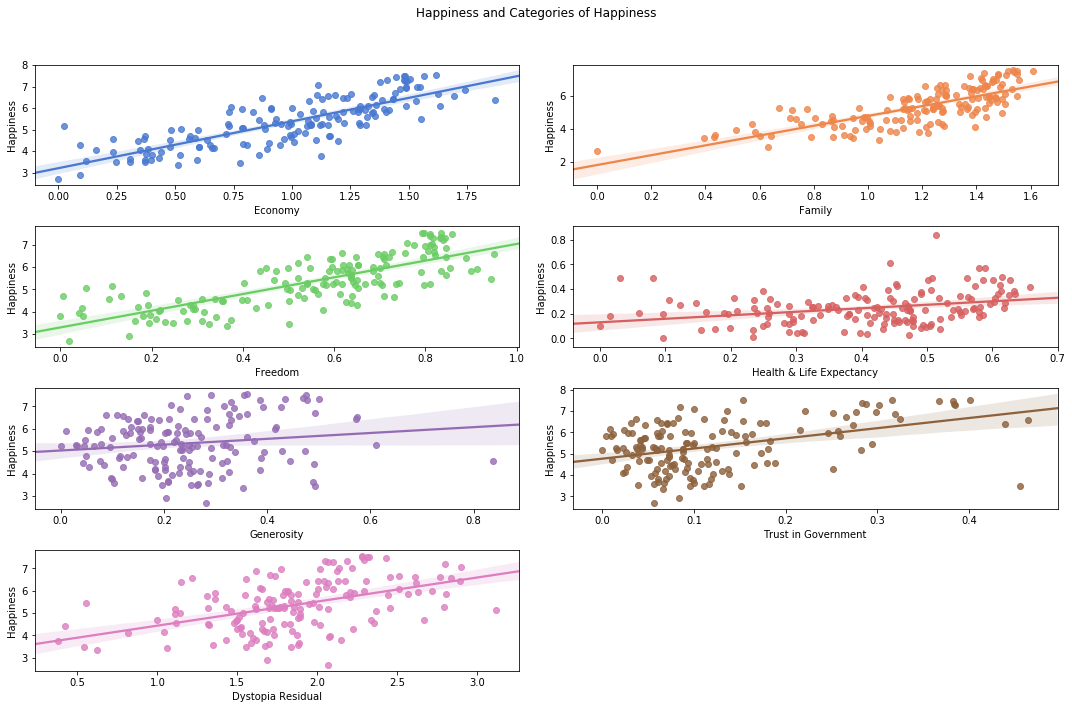

In [102]:
# plot of happiness and subtypes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
fig.suptitle("Happiness and Categories of Happiness")

sns.regplot(x="Economy..GDP.per.Capita.", y="Happiness.Score", data=whr, ax=axes[0,0])
sns.regplot(x="Family", y="Happiness.Score", data=whr, ax=axes[0,1])

axes[0,0].set_ylabel("Happiness")
axes[0,0].set_xlabel("Economy")
axes[0,1].set_ylabel("Happiness")
axes[0,1].set_xlabel("Family")

sns.regplot(x="Health..Life.Expectancy.", y="Happiness.Score", data=whr, ax=axes[1,0])
sns.regplot(x="Freedom", y="Generosity", data=whr, ax=axes[1,1])

axes[1,0].set_ylabel("Happiness")
axes[1,0].set_xlabel("Freedom")
axes[1,1].set_ylabel("Happiness")
axes[1,1].set_xlabel("Health & Life Expectancy")

sns.regplot(x="Generosity", y="Happiness.Score", data=whr, ax=axes[2,0])
sns.regplot(x="Trust..Government.Corruption.", y="Happiness.Score", data=whr, ax=axes[2,1])

axes[2,0].set_ylabel("Happiness")
axes[2,0].set_xlabel("Generosity")
axes[2,1].set_xlabel("Trust in Government")
axes[2,1].set_ylabel("Happiness")

sns.regplot(x="Dystopia.Residual", y="Happiness.Score", data=whr, ax=axes[3,0])

axes[3,0].set_xlabel("Dystopia Residual")
axes[3,0].set_ylabel("Happiness")
axes[3,1].axis("off") #https://stackoverflow.com/questions/40081489/matplotlib-odd-subplots

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# # slope and correlation coefficient of happiness and personal freedom
# x = hfi_movement_whr_happiness_by_country["pf_movement"]
# y = hfi_movement_whr_happiness_by_country["hp_score"]
# linregress(x,y)
